In [18]:
%pip install pandas matplotlib networkx neo4j seaborn

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import seaborn as sns

# Neo4j Connection Details
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def run_query(query):
    with driver.session() as session:
        return session.run(query).data()

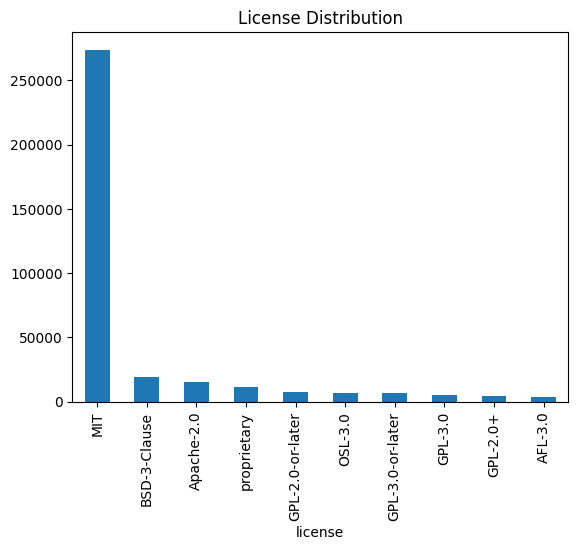

In [20]:
# 1. License Distribution
license_query = """
MATCH (p:Package)
UNWIND p.licenses AS license
RETURN license, COUNT(*) AS count
ORDER BY count DESC
LIMIT 10
"""
license_data = pd.DataFrame(run_query(license_query))
license_data.plot(kind='bar', x='license', y='count', title='License Distribution', legend=False)
plt.show()

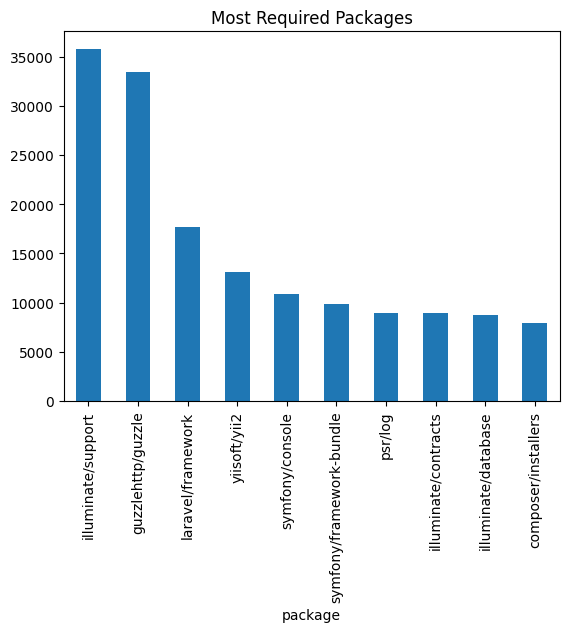

In [21]:
# 2. Most Required Packages
required_query = """
MATCH (:Package)-[:REQUIRES]->(p:Package)
RETURN p.full_name AS package, COUNT(*) AS count
ORDER BY count DESC
LIMIT 10
"""
required_data = pd.DataFrame(run_query(required_query))
required_data.plot(kind='bar', x='package', y='count', title='Most Required Packages', legend=False)
plt.show()

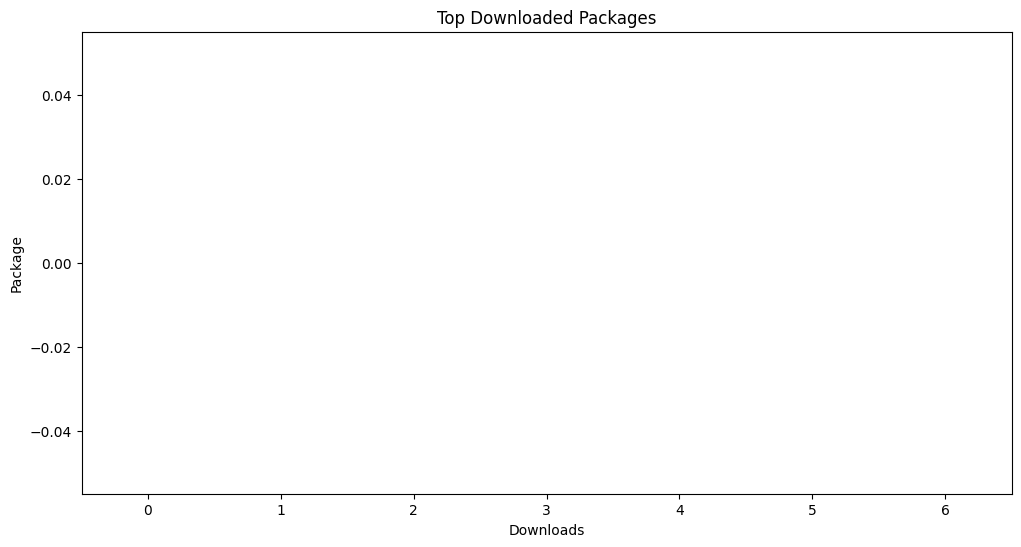

In [22]:
# 3. Most Downloaded Packages
query_top_downloaded = """
MATCH (p:Package)
WHERE p.downloads IS NOT NULL
RETURN p.full_name AS package, p.downloads AS downloads
ORDER BY downloads DESC
LIMIT 10;
"""
top_downloaded_data = run_query(query_top_downloaded)
top_downloaded_df = pd.DataFrame(top_downloaded_data, columns=["Package", "Downloads"])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_downloaded_df, x="Downloads", y="Package")
plt.title("Top Downloaded Packages")
plt.show()


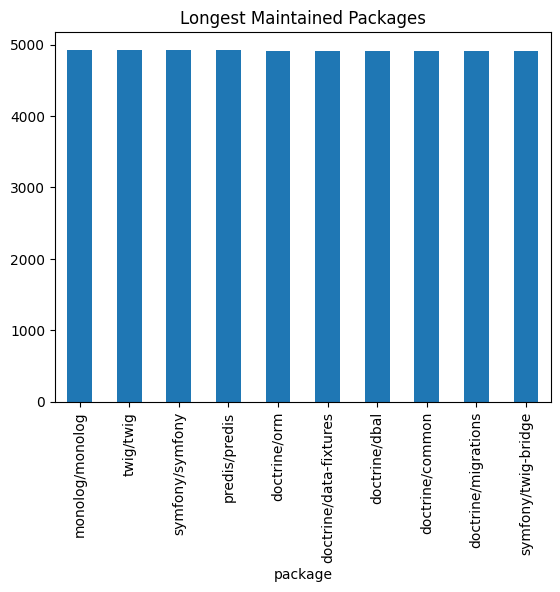

In [23]:
# 4. Package Lifespan
lifespan_query = """
MATCH (p:Package)
WHERE p.published_at IS NOT NULL AND p.updated_at IS NOT NULL
RETURN p.full_name AS package, duration.inDays(p.published_at, p.updated_at).days AS lifespan
ORDER BY lifespan DESC
LIMIT 10
"""
lifespan_data = pd.DataFrame(run_query(lifespan_query))
lifespan_data.plot(kind='bar', x='package', y='lifespan', title='Longest Maintained Packages', legend=False)
plt.show()

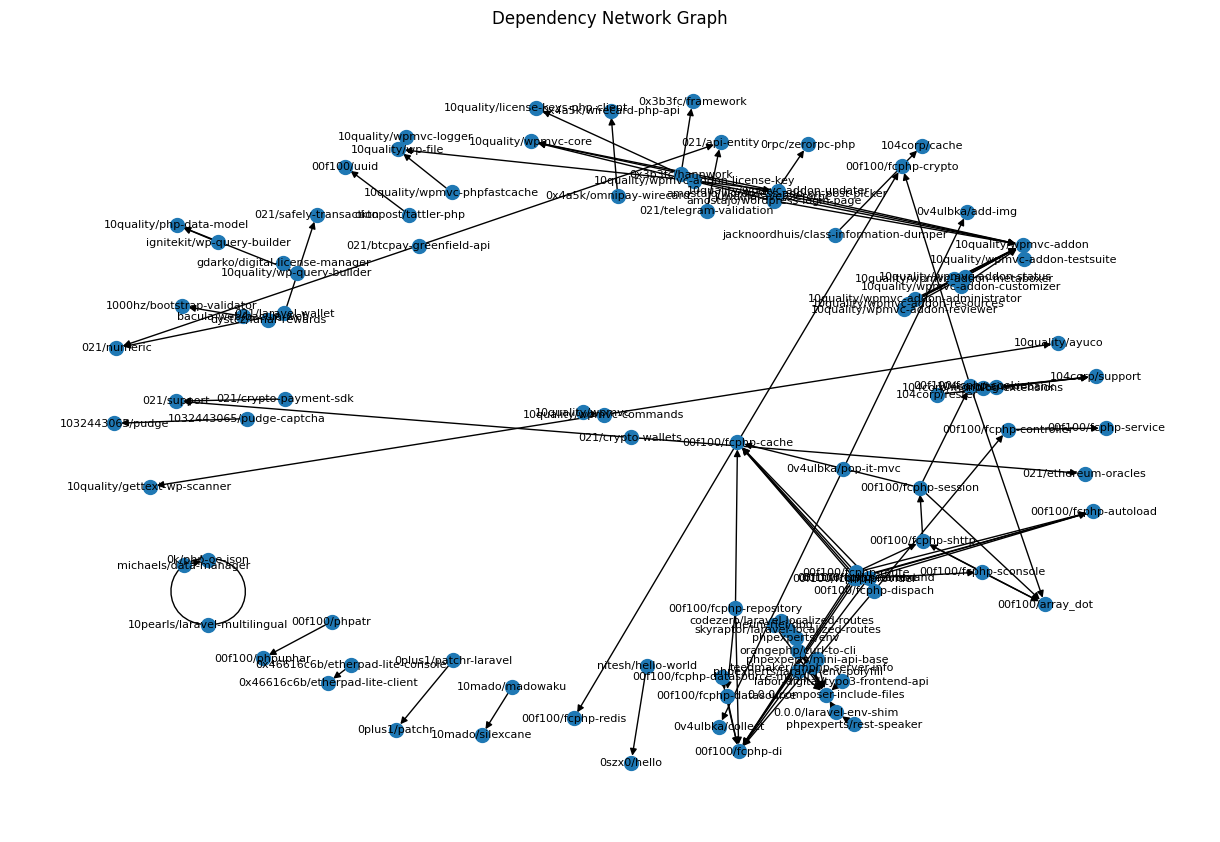

In [24]:
# 5. Dependency Network Graph
dependency_query = """
MATCH (p:Package)-[:REQUIRES]->(d:Package)
RETURN p.full_name AS package, d.full_name AS dependency
LIMIT 100
"""
graph_data = run_query(dependency_query)
G = nx.DiGraph()
G.add_edges_from([(row['package'], row['dependency']) for row in graph_data])
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=100, font_size=8)
plt.title("Dependency Network Graph")
plt.show()

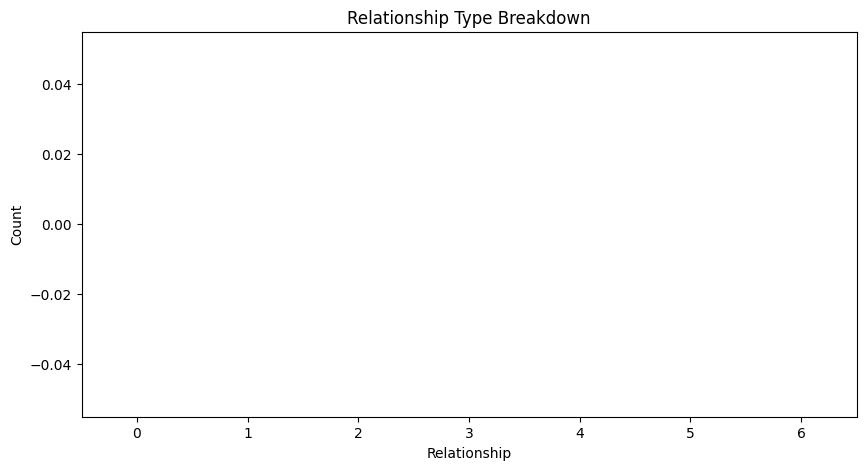

In [27]:
query_relationships = """
MATCH ()-[r]->()
RETURN type(r) AS relationship, COUNT(*) AS count
ORDER BY count DESC;
"""
relationship_data = run_query(query_relationships)
relationship_df = pd.DataFrame(relationship_data, columns=["Relationship", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(data=relationship_df, x="Relationship", y="Count")
plt.title("Relationship Type Breakdown")
plt.show()

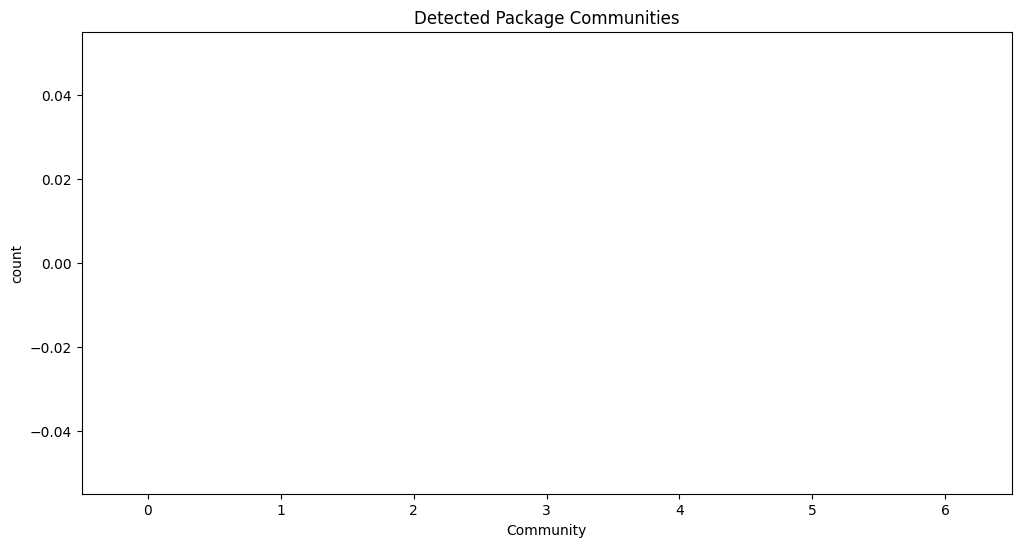

In [26]:
query_create_graph = """
CALL gds.graph.project(
    'myGraph',
    'Package',
    { REQUIRES: { orientation: 'NATURAL' } }
);
"""
run_query(query_create_graph)

query_community = """
CALL gds.louvain.stream('myGraph')
YIELD nodeId, communityId
RETURN gds.util.asNode(nodeId).full_name AS package, communityId;
"""
community_data = run_query(query_community)
community_df = pd.DataFrame(community_data, columns=["Package", "Community"])

plt.figure(figsize=(12, 6))
sns.countplot(data=community_df, x="Community", order=community_df["Community"].value_counts().index)
plt.title("Detected Package Communities")
plt.show()